# **Вариант 2**


**Цель:** Контроль пространственных размерностей через свертки и пулинг.

Спроектируйте сеть для выхода (64, 16, 16) за не более 3 слоев свертки.

**Условие:** Используйте как минимум один слой с padding=0, чтобы часть пространственной информации была потеряна. Можно менять в таких условиях kernel_size и stride.

**Эксперимент:** Сравните выход с использованием padding=0 и padding=1, оцените разницу в размерности и среднее значение активаций.

Импортируем бибилиотеки

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Функция для вывода информарции

In [53]:
def info(y,padding):
  return f'Padding = {padding}\nВыходная форма: {y.shape}\nСреднее значение активаций: {y.mean().item()}\n\n'

Фиксируем случайность для повторяемости

In [54]:
torch.manual_seed(0)

Первый класс для сети с выходом (64, 16, 16) с 1 слоем с padding=0


In [55]:
class NetPad0(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2)   # 64→32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0)  # 32→16
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

Первый класс для сети с выходом (64, 16, 16) без слоя с padding=0

In [56]:
class NetPad1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)   # 64→32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # 32→16
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

Проверка отработки

In [63]:
x = torch.randn(1, 3, 64, 64)
net0 = NetPad0()
net1 = NetPad1()

y0 = net0(x)
y1 = net1(x)

print(info(y=y0,padding=0))
print(info(y=y1,padding=1))


Padding = 0
Выходная форма: torch.Size([1, 64, 16, 16])
Среднее значение активаций: 0.09262605011463165


Padding = 1
Выходная форма: torch.Size([1, 64, 16, 16])
Среднее значение активаций: 0.09018135070800781




Графическое сранение на нескольких экспериментах

Среднее значение активаций (padding=0): 0.0977
Среднее значение активаций (padding=1): 0.0972


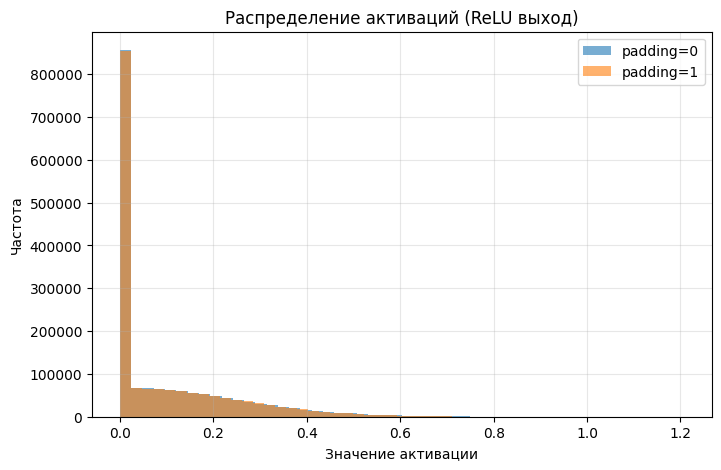

In [58]:
import matplotlib.pyplot as plt

means_0, means_1 = [], []
activations_0, activations_1 = [], []

for i in range(100):
    x = torch.randn(1, 3, 64, 64)
    y0 = net0(x)
    y1 = net1(x)
    # Находим средние значения активаций
    means_0.append(y0.mean().item())
    means_1.append(y1.mean().item())
    # Превращаем в одномерный вектор
    activations_0.append(y0.flatten().detach())
    activations_1.append(y1.flatten().detach())

# Объединяем все активации
activations_0 = torch.cat(activations_0)
activations_1 = torch.cat(activations_1)

# Выводим результаты
print(f"Среднее значение активаций (padding=0): {sum(means_0)/len(means_0):.4f}")
print(f"Среднее значение активаций (padding=1): {sum(means_1)/len(means_1):.4f}")

# Строим гистограммы
plt.figure(figsize=(8,5))
plt.hist(activations_0.numpy(), bins=50, alpha=0.6, label='padding=0')
plt.hist(activations_1.numpy(), bins=50, alpha=0.6, label='padding=1')
plt.xlabel("Значение активации")
plt.ylabel("Частота")
plt.title("Распределение активаций (ReLU выход)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Вывод:**

Разница в среднем значении активаций возникает из-за потери краевой информации при padding=0

# **Вариант 4. Сравнение GAP и Flatten**

Цель: Понимание различий между Flatten и Global Average Pooling.

Спроектируйте сеть с 3 свёрточными слоями, после которых выходной тензор (batch, 128, 8, 8).

Условие: Реализуйте два варианта классификации:
Flatten → Linear
Global Average Pooling → Linear

Эксперимент: Обучите оба варианта на данных и сравните дисперсию выходных активаций перед финальным слоем.

Импортируем библиотеки

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import Adam
from tqdm import tqdm


Подготовка датасета CIFAR-10

In [71]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

num_classes = 10

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader   = DataLoader(test_dataset, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Делаем 3 модели:

1. ConvNet - сеть с 3-мя свертками
2. FlattenClassifier - Flatten → Linear
3. GAPClassifier - Global Average Pooling → Linear

In [72]:
#  Сеть с 3 свёртками
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)   # 32x16x16
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 64x8x8
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1) # 128x8x8
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        return x

# Flatten → Linear
class FlattenClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.backbone = ConvNet()
        self.fc = nn.Linear(128*8*8, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x_flat = x.flatten(start_dim=1)
        out = self.fc(x_flat)
        return out, x_flat

# GAP → Linear
class GAPClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.backbone = ConvNet()
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x_gap = x.mean(dim=[2,3])
        out = self.fc(x_gap)
        return out, x_gap


Создаем модели

In [73]:
flatten_model = FlattenClassifier(num_classes).to(device)
gap_model     = GAPClassifier(num_classes).to(device)
models = [flatten_model, gap_model]

criterion = nn.CrossEntropyLoss()
optimizer_f = torch.optim.Adam(flatten_model.parameters(), lr=0.001)
optimizer_g = torch.optim.Adam(gap_model.parameters(), lr=0.001)

# Задаем 5 эпох обучения
num_epochs = 5

Обучение

In [74]:
for mdl in models:
  mdl.to(device)
  optimizer = Adam(mdl.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()


#for model, optimizer, name in zip([flatten_model, gap_model], [optimizer_f, optimizer_g], ["Flatten","GAP"]):
  for epoch in range(num_epochs):
    mdl.train()
    running_loss = 0.0
    total_batches = 0

    for images, labels in tqdm(train_loader, desc=f"{mdl.__class__.__name__} Epoch {epoch+1}/{num_epochs}"):
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs, _ = mdl(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      total_batches += 1

    avg_loss = running_loss / total_batches
    print(f"{mdl.__class__.__name__} - Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.4f}")

FlattenClassifier Epoch 1/5: 100%|██████████| 782/782 [00:10<00:00, 78.19it/s]


FlattenClassifier - Epoch [1/5] - Avg Loss: 1.5050


FlattenClassifier Epoch 2/5: 100%|██████████| 782/782 [00:09<00:00, 83.84it/s]


FlattenClassifier - Epoch [2/5] - Avg Loss: 1.1601


FlattenClassifier Epoch 3/5: 100%|██████████| 782/782 [00:09<00:00, 81.04it/s]


FlattenClassifier - Epoch [3/5] - Avg Loss: 0.9908


FlattenClassifier Epoch 4/5: 100%|██████████| 782/782 [00:10<00:00, 77.11it/s]


FlattenClassifier - Epoch [4/5] - Avg Loss: 0.8718


FlattenClassifier Epoch 5/5: 100%|██████████| 782/782 [00:09<00:00, 79.30it/s]


FlattenClassifier - Epoch [5/5] - Avg Loss: 0.7736


GAPClassifier Epoch 1/5: 100%|██████████| 782/782 [00:09<00:00, 80.06it/s]


GAPClassifier - Epoch [1/5] - Avg Loss: 1.8801


GAPClassifier Epoch 2/5: 100%|██████████| 782/782 [00:09<00:00, 82.34it/s]


GAPClassifier - Epoch [2/5] - Avg Loss: 1.6112


GAPClassifier Epoch 3/5: 100%|██████████| 782/782 [00:09<00:00, 81.89it/s]


GAPClassifier - Epoch [3/5] - Avg Loss: 1.5092


GAPClassifier Epoch 4/5: 100%|██████████| 782/782 [00:09<00:00, 79.92it/s]


GAPClassifier - Epoch [4/5] - Avg Loss: 1.4362


GAPClassifier Epoch 5/5: 100%|██████████| 782/782 [00:09<00:00, 80.10it/s]

GAPClassifier - Epoch [5/5] - Avg Loss: 1.3732


На тесте

In [75]:
flatten_model.eval()
gap_model.eval()

act_flat_list = []
act_gap_list  = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        _, act_f = flatten_model(images)
        _, act_g = gap_model(images)
        act_flat_list.append(act_f.flatten(start_dim=1))
        act_gap_list.append(act_g.flatten(start_dim=1))

act_flat = torch.cat(act_flat_list)
act_gap  = torch.cat(act_gap_list)

Вывод значений дисперсий

In [76]:
var_flat = act_flat.var(dim=0).mean().item()
var_gap  = act_gap.var(dim=0).mean().item()

print("\nСредняя дисперсия активаций на тесте:")
print("Flatten:", var_flat)
print("GAP    :", var_gap)


Средняя дисперсия активаций на тесте:
Flatten: 0.018441565334796906
GAP    : 0.3386375904083252


Вывод:

**GAP** уменьшает размерность признаков, но за счёт усреднения по пространству активации становятся более выраженными и разбросанными, что даёт большую среднюю дисперсию на уровне нейронов перед Linear.


**Flatten** сохраняет локальные детали, но усреднение по тысячам пикселей даёт меньшую среднюю дисперсию.